In [1]:
import re
import numpy     as np
import pandas    as pd
import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## Ciudad

Usamos las formas de los barrios de la Ciudad para conformar su forma, útil para confinar el análsis a sus fines (fronteras).

In [2]:
barrios = gpd.read_file('barrios/barrios.shp')

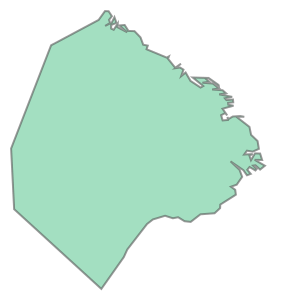

In [3]:
ciudad = barrios.buffer(0.001).unary_union.simplify(100)[1]
ciudad

## Colectivos

In [4]:
bondis = gpd.read_file('recorridos/recorridos_de_colectivos.shp')

Los datos vienen algo desprolijos y en una sola columna. Los parseamos para
* separarlos en distintas columnas y
* estandarizar el _tipo de servicio_.

In [5]:
regexp = re.compile('(?P<línea>\d+) ramal (?P<ramal>\w+) \((?P<sentido>\w+)\)-?(?P<tipo>.*)')

In [6]:
df = bondis.descriptio.apply(lambda x: pd.Series(regexp.match(x).groupdict()))

In [7]:
nuevo_tipo = {'Común Básico':'común',
              'Comun Básico':'común',
              'Expreso':'otro',
              'Diferencial':'otro',
              'Expreso Diferencial':'otro',
              'Fraccionamiento':'otro',
              '':'otro'}

In [8]:
df.tipo = df.tipo.map(nuevo_tipo)

In [9]:
bondis = gpd.GeoDataFrame(df, crs=bondis.crs, geometry=bondis.geometry)

Solo nos quedamos con el tipo de servicio _común_.

In [10]:
bondis = bondis[bondis.tipo == 'común']

(0.0, 160000.0, 20000.0, 160000.0)

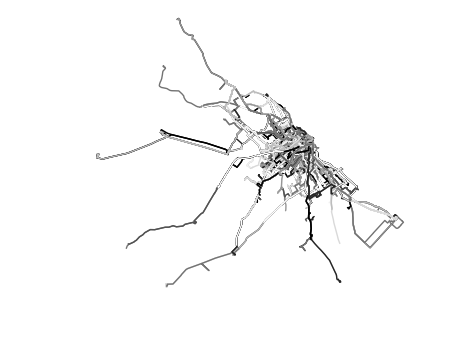

In [11]:
bondis.plot()
plt.axis('off')

## Grilla hexagonal

Obtenemos las coordenadas de la caja que contiene a la ciudad en longitud y latitud. Preparamos coordenadas para crear una grilla triangular dentro de la caja. Ver https://en.wikipedia.org/wiki/Hexagonal_lattice.

In [12]:
xmin, ymin, xmax, ymax = ciudad.bounds

R = ancho_triángulo = 350 # radio hexágonos (metros)
alto_triángulo = np.sqrt(3) / 2 * ancho_triángulo

xs = np.arange(xmin - ancho_triángulo, xmax + ancho_triángulo, ancho_triángulo)

ys = np.arange(ymin - alto_triángulo, ymax + alto_triángulo, alto_triángulo)

Armamos una grilla triangular de triángulos equiláteros. Es básicamente una grilla cuadrada (de rectángulos en realidad, con dimensiones `ancho_triángulo · alto_triángulo`) con los puntos de las filas impares desplazados una distancia `ancho_triángulo / 2` hacia la derecha.

In [19]:
triangular = np.empty((len(ys), len(xs)), dtype='object')

for ix, x in enumerate(xs):
    for iy, y in enumerate(ys):
        triangular[iy][ix] = (x, y) if iy % 2 == 0 else (x + ancho_triángulo / 2, y)

Ahora vamos a ir de una grilla triangular a una hexagonal. Un hexágono regular está compuesto por seis triángulos equiláteros.

Las siguientes dos funciones determinan las coordenadas necesarias para construir una forma hexagonal a partir de una grilla triangular `D` y un punto central `(ix, iy)`.

In [20]:
# caso A: hexágonos en filas pares
def hex_par(D, ix, iy):
    a = D[iy  ][ix+1]
    b = D[iy-1][ix  ]
    c = D[iy-1][ix-1]
    d = D[iy  ][ix-1]
    e = D[iy+1][ix-1]
    f = D[iy+1][ix  ]
    
    return a, b, c, d, e, f

# caso B: hexágonos en filas impares
def hex_impar(D, ix, iy):
    a = D[iy  ][ix-1]
    b = D[iy+1][ix  ]
    c = D[iy+1][ix+1]
    d = D[iy  ][ix+1]
    e = D[iy-1][ix+1]
    f = D[iy-1][ix  ]
    
    return a, b, c, d, e, f

In [21]:
hexagonal = []

for ix in range(1, len(xs) - 1):
    for iy in range(1, len(ys) - 1):
        
        if   iy % 2 == 0 and ix % 3 == 0: # caso A
            hexagonal.append( Polygon(hex_par(  triangular, ix, iy)) )
        elif iy % 2 == 1 and ix % 3 == 1: # caso B
            hexagonal.append( Polygon(hex_impar(triangular, ix, iy)) )

A esta altura lo que está pasando debe ser confuso. Tuve que hacer varios dibujos hasta encontrarle la vuelta.

In [22]:
h = gpd.GeoDataFrame(crs=bondis.crs, geometry=hexagonal)

In [23]:
h = h[h.intersects(ciudad)]

(90000.0, 115000.0, 90000.0, 115000.0)

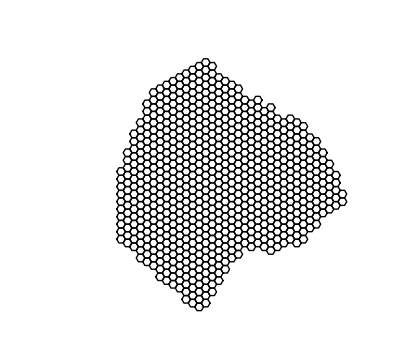

In [24]:
h.plot(facecolor='#ffffff')
plt.axis('off')

Los hexágonos son para colorear el mapa. ¡En realidad vamos a usar círculos!

In [25]:
c = gpd.GeoDataFrame(crs=bondis.crs, geometry=h.centroid.buffer(R)) # radio círculos = radio de los hexágonos

(90000.0, 115000.0, 90000.0, 115000.0)

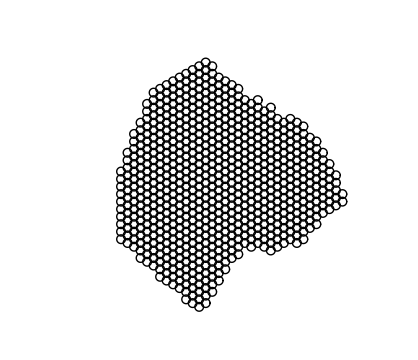

In [26]:
c.plot(facecolor='#ffffff')
plt.axis('off')

## Conectividad

Primer paso: hacemos un JOIN entre los recorridos de los colectivos (que son polilíneas en el plano) y los círculos de la grilla (polígonos), a partir de ahora **sectores**. La condición es que se intersequen.

_Determinamos qué líneas circulan por cada sector_.

In [27]:
guía_t = gpd.sjoin(c, bondis, how='inner', op='intersects')

guía_t.reset_index(inplace=True)
guía_t.rename(columns={'index':'sector', 'index_right':'recorrido'}, inplace=True)
guía_t = guía_t[['sector','recorrido']]

Segundo paso: hacemos un SELF JOIN sobre la columna `recorrido`.

_Obtenemos las vinculaciones entre sectores_.

In [28]:
tt = pd.merge(guía_t, guía_t, on='recorrido', suffixes=('_origen', '_destino'))

tt = tt[tt.sector_origen != tt.sector_destino] # no nos interesa la vinculación de un sector consigo mismo

Tercer paso: agrupamos por sector de origen y contamos los **distintos** sectores de destino; por eso el `unique().size` en vez de un simple `count()`.

_Computamos la conectividad_.

In [29]:
h['puntaje'] = tt.groupby('sector_origen').sector_destino.agg(lambda x: x.unique().size)
h.fillna(0, inplace=True)

Finalmente hacemos un histograma y exportamos el trabajo.

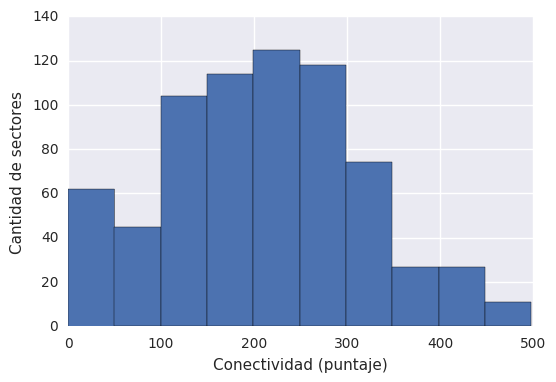

In [30]:
h.hist()
plt.xlabel('Conectividad (puntaje)')
plt.ylabel('Cantidad de sectores')
plt.title('')
plt.savefig('histograma.png')

**EPSG**
* 3857 Google Maps
* 4326 

In [36]:
h[h.puntaje != 0].to_crs({'init': 'epsg:3857'}).to_file('bondis.geojson', driver='GeoJSON')